# Assignment 1

## Analyze data

In [1]:
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('flight_delay.csv')

print("First n rows:")
display(data.head())

print()
print("Data info:")
data.info()

print()
print("Describe delay column")
display(data.describe())

#Check fo nans
print("Is there are any nulls:", data.isnull().values.any())

First n rows:


,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0
2,SVO,2015-10-27 10:45:00,MIA,2015-10-27 23:35:00,0.0
3,SVO,2015-10-27 12:30:00,LAX,2015-10-28 01:20:00,0.0
4,OTP,2015-10-27 14:15:00,SVO,2015-10-27 16:40:00,9.0



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675513 entries, 0 to 675512
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Depature Airport         675513 non-null  object 
 1   Scheduled depature time  675513 non-null  object 
 2   Destination Airport      675513 non-null  object 
 3   Scheduled arrival time   675513 non-null  object 
 4   Delay                    675513 non-null  float64
dtypes: float64(1), object(4)
memory usage: 25.8+ MB

Describe delay column


,Delay
count,675513.000000
mean,9.912939
std,44.895875
min,0.000000
25%,0.000000
50%,0.000000
75%,5.000000
max,1436.000000


Is there are any nulls: False


## Preprocess data

In [2]:
from sklearn.preprocessing import LabelEncoder
data["Scheduled arrival time"] = pd.to_datetime(data["Scheduled arrival time"])
data["Scheduled depature time"] = pd.to_datetime(data["Scheduled depature time"])
data["Duration"] = (data["Scheduled arrival time"] - data["Scheduled depature time"]).dt.seconds/60
data["arrival month"] = data["Scheduled arrival time"].dt.month
data["arrival day"] = data["Scheduled arrival time"].dt.day
data["arrival day_of_week"] = data["Scheduled arrival time"].dt.day_of_week
data["departure month"] = data["Scheduled depature time"].dt.month
data["departure day"] = data["Scheduled depature time"].dt.day
data["departure day_of_week"] = data["Scheduled depature time"].dt.day_of_week
data["departure year"] = data["Scheduled depature time"].dt.year
data.drop(columns=["Scheduled arrival time", "Scheduled depature time"], inplace=True)

print("Unique numbers of departure airports:", len(data["Depature Airport"].unique()))
print("Unique numbers of destination airports:", len(data["Destination Airport"].unique()))
le = LabelEncoder()
data["Depature Airport"] = le.fit_transform(data["Depature Airport"])
data["Destination Airport"] = le.fit_transform(data["Destination Airport"])

print("Data shape", data.shape)

Unique numbers of departure airports: 179
Unique numbers of destination airports: 177
Data shape (675513, 11)


## Some charts

### Duration-delay chart

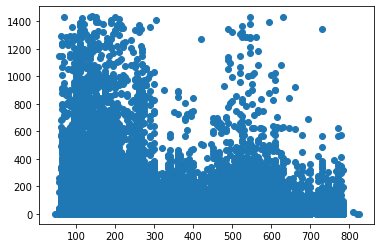

In [3]:
plt.scatter(data["Duration"], data["Delay"])
plt.savefig('Scatter duration-delay.png')
plt.show()

### Delay histogram

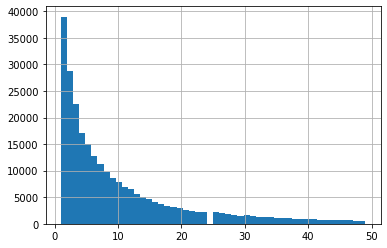

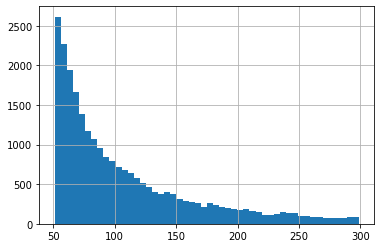

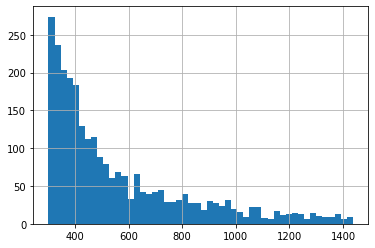

In [4]:
data["Delay"][(data["Delay"] > 0) & (data["Delay"] < 50)].hist(bins=50)
plt.savefig('Delay under 50.png')
plt.show()

data["Delay"][(data["Delay"] > 50) & (data["Delay"] < 300)].hist(bins=50)
plt.savefig('Delay over 50 and under 300.png')
plt.show()

data["Delay"][(data["Delay"] > 300)].hist(bins=50)
plt.savefig('Delay over 300.png')
plt.show()

### Normalize duration column

In [5]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()

data["Duration"] = rs.fit_transform(data["Duration"].values[:, None])

## Split data to train and test

In [6]:
train_data = data[data['departure year'] < 2018]
test_data = data[data['departure year'] >= 2018]
trainY = train_data["Delay"]
trainX= train_data.drop(columns=["Delay", 'departure year'])
testY = test_data["Delay"]
testX= test_data.drop(columns=["Delay", 'departure year'])

## Find outliers and remove it

In [7]:
import numpy as np
from sklearn.ensemble import IsolationForest

train_data = train_data.drop(columns=['departure year'])
oulier_detector = IsolationForest(n_estimators=200, contamination=0.05, n_jobs=-1)
outliers = oulier_detector.fit_predict(train_data)
print("Unique numbers for outliers:", np.unique(outliers))
print(f"Number of outliers: {(outliers == -1).sum()} of {len(outliers)}")

Unique numbers for outliers: [-1  1]
Number of outliers: 24954 of 499062


### Outliers chart

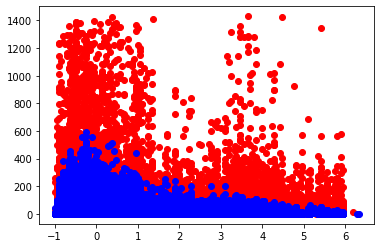

In [9]:
plt.scatter(train_data["Duration"][outliers == -1], train_data["Delay"][outliers == -1], c='r')
plt.scatter(train_data["Duration"][outliers == 1], train_data["Delay"][outliers == 1], c='b')
plt.savefig('Outliers.png')
plt.show()

In [10]:
trainX = trainX[outliers == 1]
trainY = trainY[outliers == 1]

## Machine learning models

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

### Linear regression

In [12]:
LR = LinearRegression(n_jobs=-1)
LR.fit(trainX, trainY)
pred = LR.predict(testX)
print("Error for linear regression (MSE):", mean_squared_error(testY, pred))
print("Error for linear regression (MAE):", mean_absolute_error(testY, pred))
pred_train = LR.predict(trainX)
print("Error for linear regression (MSE) on train dataset:", mean_squared_error(trainY, pred_train))
print("Error for linear regression (MAE) on train dataset:", mean_absolute_error(trainY, pred_train))

Error for linear regression (MSE): 1602.0938487674096
Error for linear regression (MAE): 10.897530631548038
Error for linear regression (MSE) on train dataset: 353.3478244008921
Error for linear regression (MAE) on train dataset: 9.036420268469257


### Ridge regression

In [13]:
ridge = Ridge()
gridParams = {"alpha": np.linspace(0.1, 10, 10)}
grid = GridSearchCV(ridge, gridParams, scoring='neg_mean_squared_error',
                    verbose=1, n_jobs=-1, cv=5)
grid.fit(trainX, trainY)
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)
print("Error for ridge regression (MSE):", mean_squared_error(testY, grid.predict(testX)))
print("Error for ridge regression (MAE):", mean_absolute_error(testY, grid.predict(testX)))
pred_train = grid.predict(trainX)
print(f"MSE for lasso regression on train dataset:", mean_squared_error(trainY, pred_train))
print(f"MAE for lasso regression on train dataset:", mean_absolute_error(trainY, pred_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'alpha': 10.0}
Best score: -354.15000155743064
Error for ridge regression (MSE): 1602.0939636896237
Error for ridge regression (MAE): 10.897532105646288
MSE for lasso regression on train dataset: 353.34782605646086
MAE for lasso regression on train dataset: 9.036421060480894


### Lasso regression

In [13]:
lasso = Lasso()
gridParams = {"alpha": np.linspace(0.1, 4, 5)}
grid = GridSearchCV(lasso, gridParams, scoring='neg_mean_squared_error',
                    verbose=1, n_jobs=-1, cv=5)
grid.fit(trainX, trainY)           
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)
print("Error for lasso regression (MSE):", mean_squared_error(testY, grid.predict(testX)))
print("Error for lasso regression (MAE):", mean_absolute_error(testY, grid.predict(testX)))
pred_train = grid.predict(trainX)
print(f"MSE for lasso regression on train dataset:", mean_squared_error(trainY, pred_train))
print(f"MAE for lasso regression on train dataset:", mean_absolute_error(trainY, pred_train))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'alpha': 0.1}
Best score: -317.37156327319826
Error for lasso regression (MSE): 1600.912197586982
Error for lasso regression (MAE): 10.76436295600736
MSE for lasso regression on train dataset: 316.6955182753042
MAE for lasso regression on train dataset: 8.745299633437313


### Polynomial regression

In [14]:
degrees = [2, 3, 4]
for degree in degrees:
    poly = PolynomialFeatures(degree)
    poly.fit(trainX)
    polyXtrain = poly.transform(trainX)
    polyXtest = poly.transform(testX)
    lr = LinearRegression()
    lr.fit(polyXtrain, trainY)
    pred = lr.predict(polyXtest)
    print(f"MSE for linear regression with degree {degree} :", mean_squared_error(testY, pred))
    print(f"MAE for linear regression with degree {degree} :", mean_absolute_error(testY, pred))
    pred_train = lr.predict(polyXtrain)
    print(f"MSE for linear regression with degree {degree} on train dataset:", mean_squared_error(trainY, pred_train))
    print(f"MAE for linear regression with degree {degree} on train dataset:", mean_absolute_error(trainY, pred_train))

MSE for linear regression with degree 2 : 1606.5179820916965
MAE for linear regression with degree 2 : 10.743942390952325
MSE for linear regression with degree 2 on train dataset: 314.9344927109354
MAE for linear regression with degree 2 on train dataset: 8.718238688664616
MSE for linear regression with degree 3 : 1605.6039575035386
MAE for linear regression with degree 3 : 10.702229858822902
MSE for linear regression with degree 3 on train dataset: 314.19726521120253
MAE for linear regression with degree 3 on train dataset: 8.690438366683237
MSE for linear regression with degree 4 : 1617.315643327929
MAE for linear regression with degree 4 : 10.972191940199252
MSE for linear regression with degree 4 on train dataset: 312.66473242874866
MAE for linear regression with degree 4 on train dataset: 8.635908529192344
